# PIV analysis

In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 9
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib as mpl

In [2]:
#import json
#from scipy import stats
#import scipy.interpolate as interp
#import sys
#sys.path.append('/home/claudio/Documents/Atos/pyModules')
import naca
from piv_op import *

In [3]:
from skimage import io
from skimage import exposure
from skimage.morphology import disk
from skimage.filters.rank import maximum, minimum
from skimage.filters import gaussian
from skimage import img_as_ubyte, img_as_float
from skimage.feature import register_translation

## Read images

In [4]:
#im_a = io.imread('./images/naca23012_dinamico_24deg_30ms_fin2_1_a.bmp', as_grey=True)
#im_b = io.imread('./images/naca23012_dinamico_24deg_30ms_fin2_1_b.bmp', as_grey=True)

im_a = io.imread('./images/naca23012_dinamico_24deg_fin1_1_a.bmp', as_grey=True)
im_b = io.imread('./images/naca23012_dinamico_24deg_fin1_1_b.bmp', as_grey=True)

In [5]:
px_mm = 82./1024
Dt = 10e-6

In [6]:
img = [[im_a, 'Image A'], [im_b, 'Image B']]

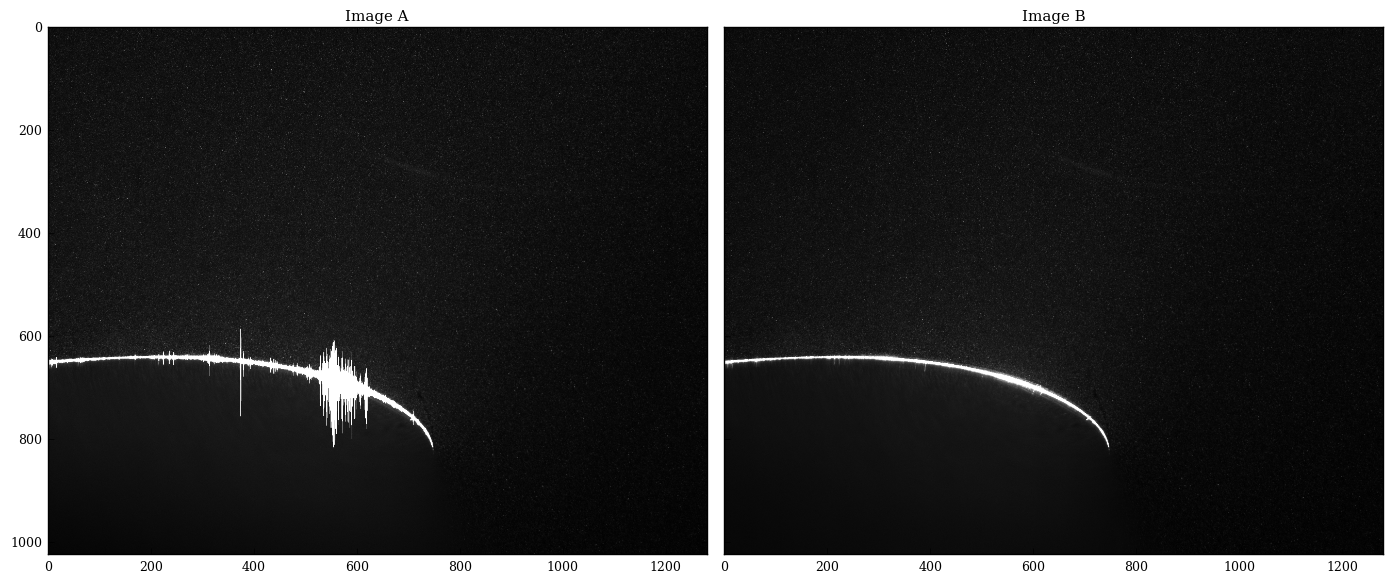

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True, subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

for i in range(2):
    ax[i].imshow(img[i][0], cmap=plt.cm.gray)
    ax[i].set_title(img[i][1])

#for a in ax.ravel():
#    a.axis('off')

fig.tight_layout()

Size of images

In [8]:
im_a.shape

(1024, 1280)

# Preprocess

## Histogram

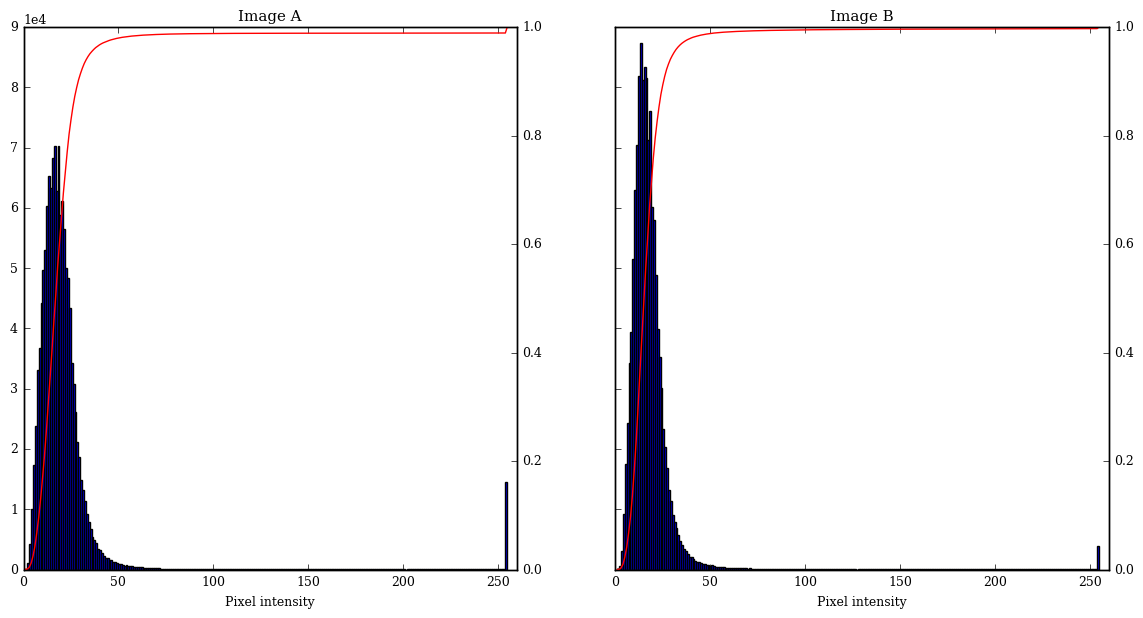

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True, subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()
bins = 256



for i in range(2):
    ax_cdf = ax[i].twinx()
    ax[i].hist(img[i][0].ravel(), bins=bins)
    ax[i].ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax[i].set_xlabel('Pixel intensity')
    ax[i].set_xlim(0, 260)
    ax[i].set_title(img[i][1])
    img_cdf, bins1 = exposure.cumulative_distribution(img[i][0], bins)
    ax_cdf.plot(bins1, img_cdf, 'r')


## Min Max Filter

In [10]:
img_f = []

for i in range(2):
    ul = maximum(img[i][0], disk(5))
    #ul = gaussian(ul, sigma=1. , mode='constant')
    il = minimum(img[i][0], disk(5))
    #il = gaussian(il, sigma=1. , mode='constant')
    img[i].append((img[i][0] - il)/(ul - il))

/home/claudio/.local/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in divide


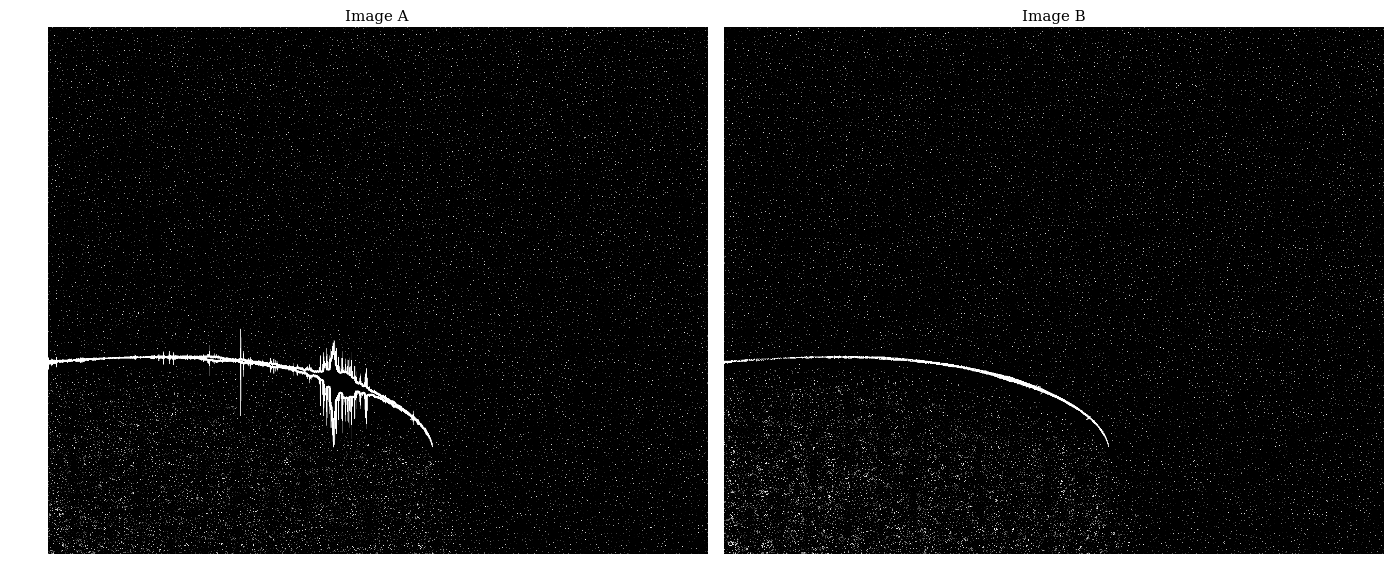

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True, subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

for i in range(2):
    ax[i].imshow(img[i][2], cmap=plt.cm.gray)
    ax[i].set_title(img[i][1])

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

## Histogram
compute histograms of filtered images

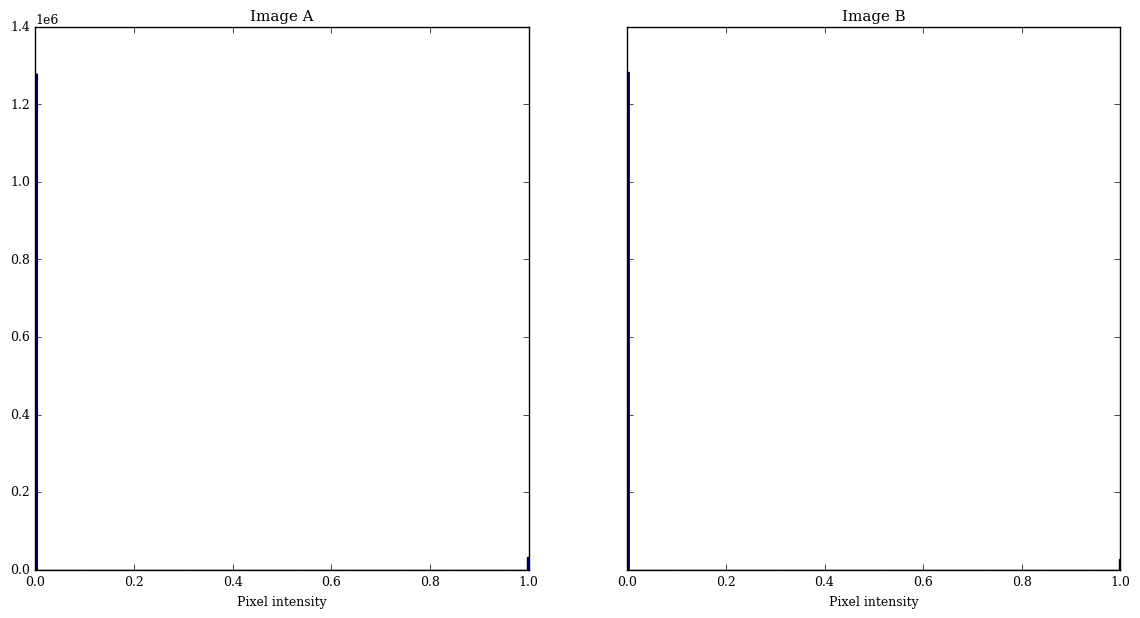

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True, subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()
bins = 256



for i in range(2):
    #ax_cdf = ax[i].twinx()
    ax[i].hist(img[i][2].ravel(), bins=bins)
    ax[i].ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax[i].set_xlabel('Pixel intensity')
    #ax[i].set_xlim(0, 260)
    ax[i].set_title(img[i][1])
    #img_cdf, bins1 = exposure.cumulative_distribution(img[i][2], bins)
    #ax_cdf.plot(bins1, img_cdf, 'r')


# Correlation

Naive correlation

In [13]:
window_size = 64
max_ext = 8

In [14]:
dim_y, dim_x = img[0][0].shape

n_wind_x = (dim_x-2*max_ext)/window_size
n_wind_y = (dim_y-2*max_ext)/window_size

In [27]:
corr_data = []

corr_data_norm = []

corr_data_SK = []

for y0 in range(max_ext,dim_y-max_ext-window_size,window_size):
    for x0 in range(max_ext,dim_x-max_ext-window_size,window_size):
        xc = x0+window_size/2
        yc = y0+window_size/2
        #print xc,yc
        corr_m = corr_wind(img[0][0],img[1][0],window_size,max_ext,y0,x0)
        dy,dx = find_best_corr(corr_m)
        
        deltay = -(dy-max_ext)
        deltax = -(dx-max_ext)
        
        corr_data.append([yc,xc, deltay, deltax,
                          np.sqrt(deltay**2+deltax**2),
                          np.rad2deg(np.arctan2(deltay,deltax))])

        corr_m = normalized_corr_wind(img[0][0],img[1][0],window_size,max_ext,y0,x0)
        dy1,dx1 = find_best_corr(corr_m, find_max = True)

        #eps_y, eps_x = subpixel(corr_m,dy1,dx1)
        eps_y = 0.0
        eps_x = 0.0
        
        deltay = -(dy1+eps_y-max_ext)
        deltax = -(dx1+eps_x-max_ext)
        corr_data_norm.append([yc,xc, deltay, deltax,
                               np.sqrt(deltay**2+deltax**2),
                               np.rad2deg(np.arctan2(deltay,deltax))])
        
        shift = corr_wind_SK(img[0][0],img[1][0],window_size,max_ext,y0,x0)
        corr_data_SK.append([yc,xc,-shift[0], -shift[1], 
                             np.sqrt(shift[1]**2 + shift[0]**2), 
                             np.rad2deg(np.arctan2(-shift[0],-shift[1])) ])

In [28]:
xp, yp = naca.naca5('23012',500)
n = len(xp)
x23012 = np.zeros(n)
y23012 = np.zeros(n)

k_sc = 300/82.*1024.
angle = np.deg2rad(7.2)

for i in range(n):
    x23012[i] = 750 - (xp[i]*np.cos(angle) + yp[i]*np.sin(angle) ) * k_sc
    y23012[i] = 840 + (xp[i]*np.sin(angle) - yp[i]*np.cos(angle) ) * k_sc


In [29]:
#plt.figure()
#plt.plot(760-x23012,810-y23012)
#plt.xlim([0,1000])
#plt.ylim([0,1000])
#plt.axis('equal')

In [30]:
x_v = [300, 1280, 1280]
y_v = [0, 700, 0]

In [31]:
cmap = plt.cm.jet
cNorm  = colors.Normalize(vmin=0.0, vmax=5.)
scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=cmap)

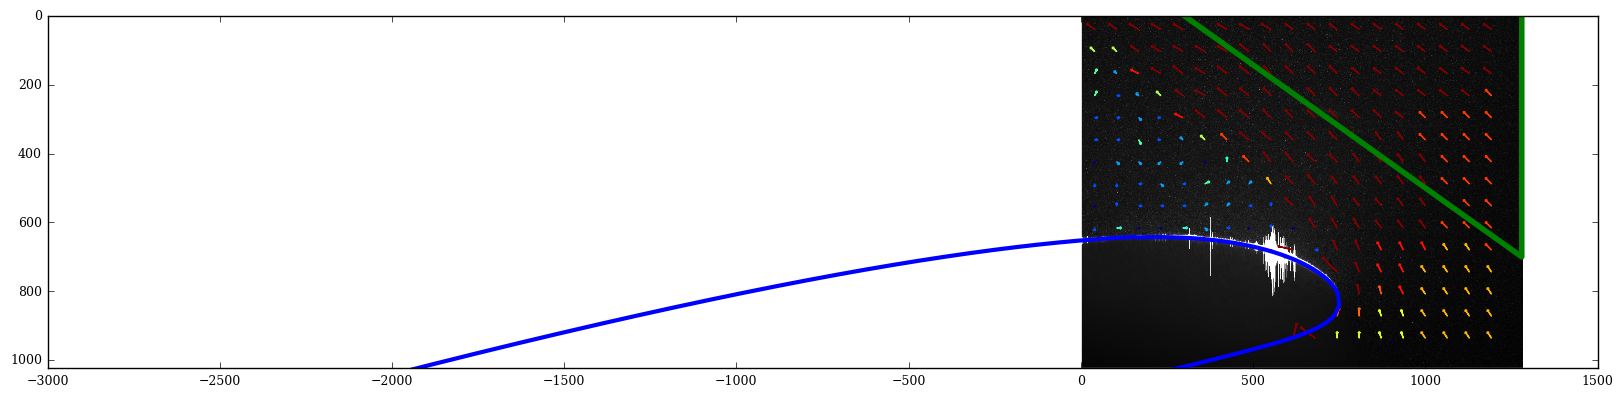

In [50]:
plt.figure(figsize=(20,16))

plt.imshow(img[0][0], cmap=plt.cm.gray)
for d in corr_data_norm:#[:4]:
    if not point_inside_polygon(d[1],d[0],x23012, y23012):
        colorVal = scalarMap.to_rgba(d[4])
        plt.arrow(d[1],d[0],5*d[3],5*d[2], head_width=7, head_length=4, color=colorVal)

#plt.gca().invert_yaxis()
plt.plot(x23012,y23012,lw=3)
plt.plot(x_v, y_v, lw=4)
#plt.xlim([0,dim_x])
plt.ylim([0,dim_y])
plt.ylim(plt.ylim()[::-1]);

#cb1 = mpl.colorbar.ColorbarBase(axc, cmap=cmap, norm=cNorm,orientation='vertical');


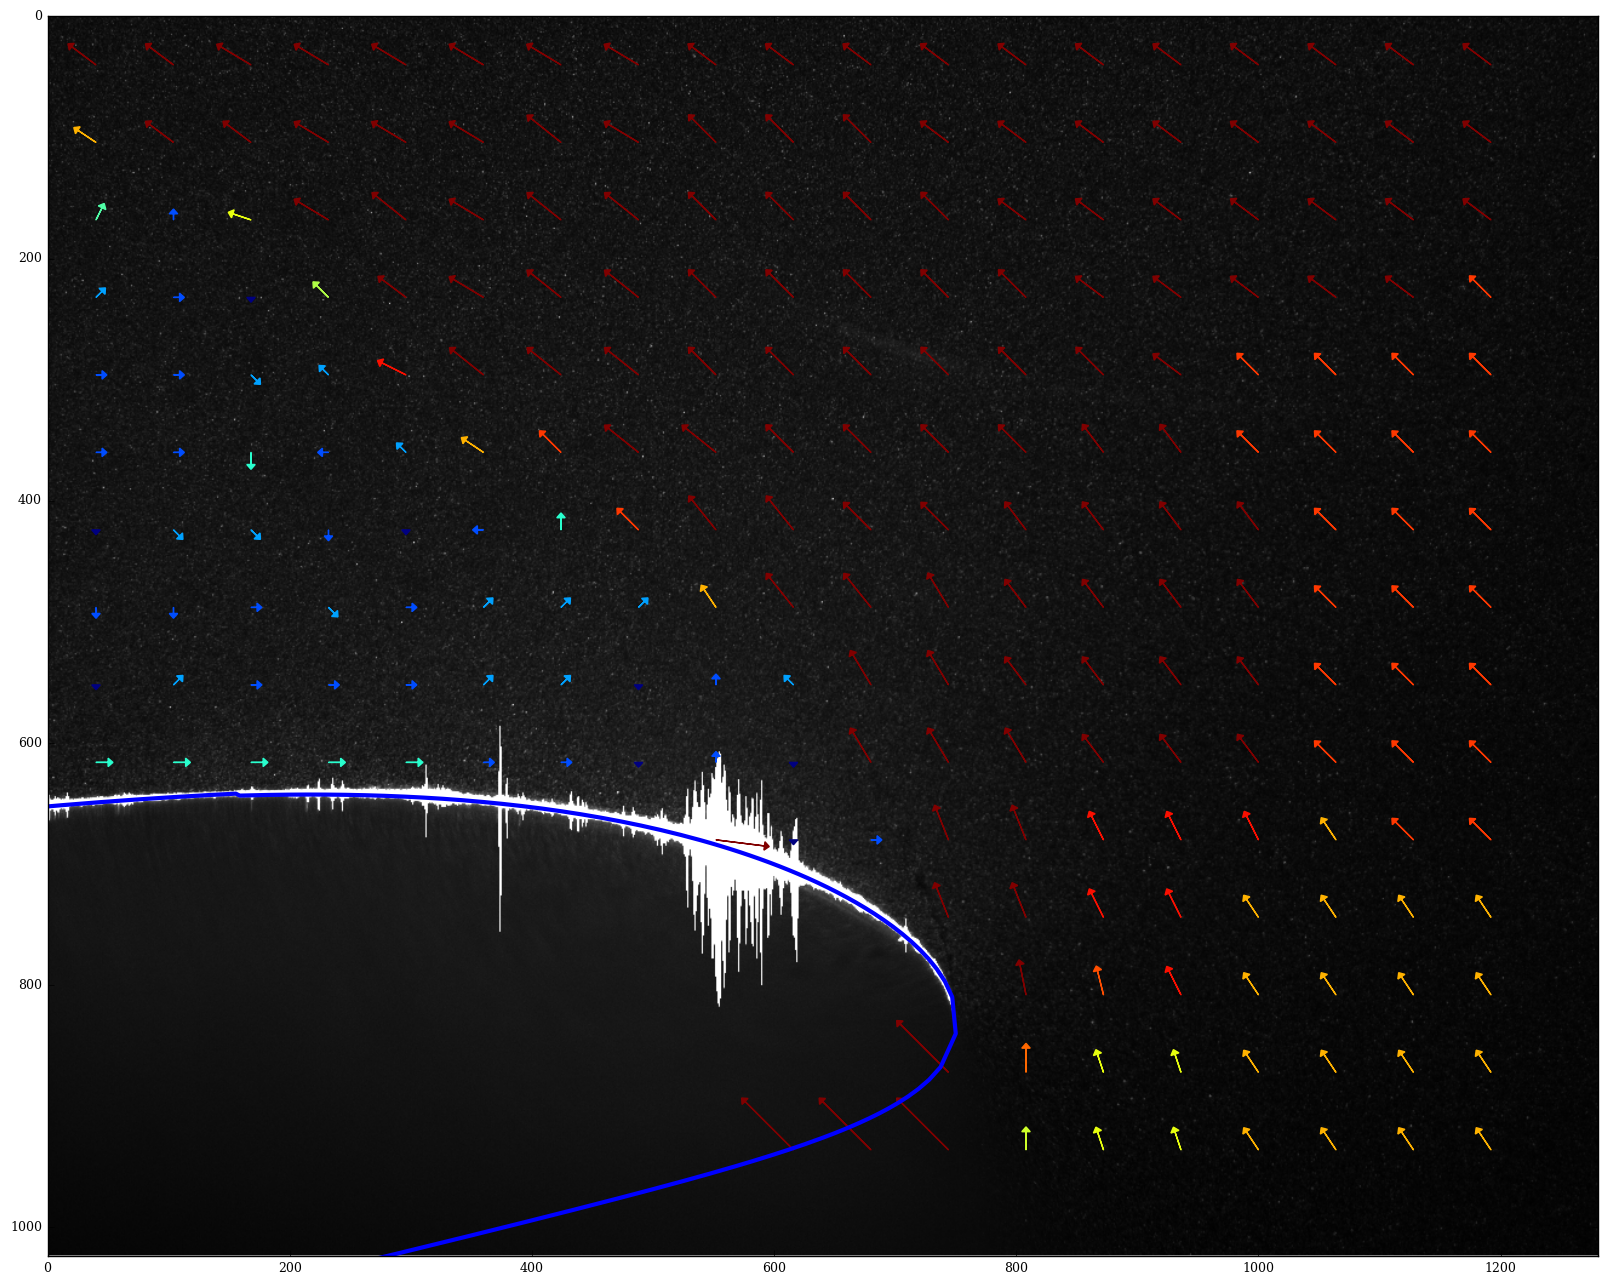

In [33]:
#d = corr_data[0]

plt.figure(figsize=(20,16))
plt.imshow(img[0][0], cmap=plt.cm.gray)
for d in corr_data:#[:4]:
    if not point_inside_polygon(d[1],d[0],x23012, y23012):
        colorVal = scalarMap.to_rgba(d[4])
        plt.arrow(d[1],d[0],5*d[3],5*d[2], head_width=7, head_length=4, color=colorVal)

#plt.gca().invert_yaxis()
plt.plot(x23012,y23012,lw=3)
plt.xlim([0,dim_x])
plt.ylim([0,dim_y])
plt.ylim(plt.ylim()[::-1]);

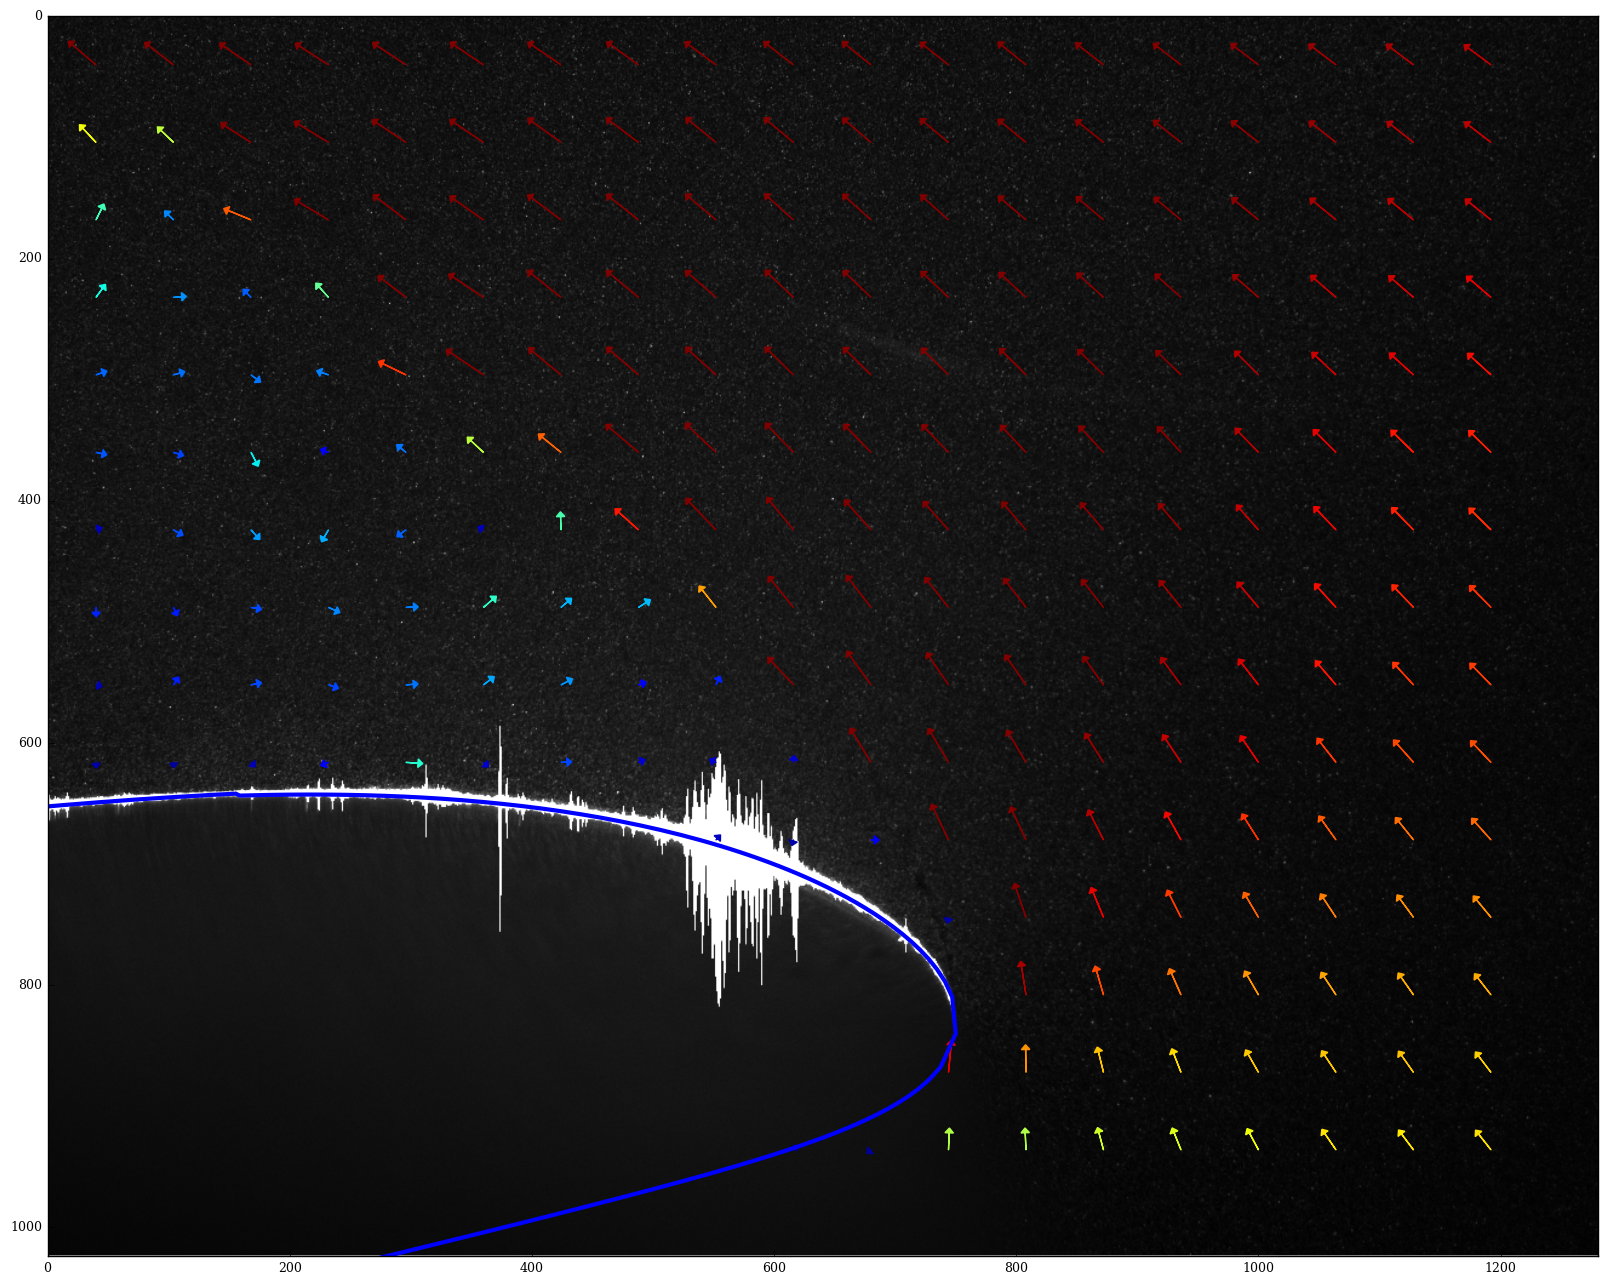

In [34]:

plt.figure(figsize=(20,16))
plt.imshow(img[0][0], cmap=plt.cm.gray)
for d in corr_data_SK:#[:4]:
    if not point_inside_polygon(d[1],d[0],x23012, y23012):
        colorVal = scalarMap.to_rgba(d[4])
        plt.arrow(d[1],d[0],5*d[3],5*d[2], head_width=7, head_length=4, color=colorVal)

#plt.gca().invert_yaxis()
plt.plot(x23012,y23012,lw=3)
plt.xlim([0,dim_x])
plt.ylim([0,dim_y])
plt.ylim(plt.ylim()[::-1]);

In [35]:
v1 = np.mean([d[4] for d in corr_data  if point_inside_polygon(d[1],d[0],x_v,y_v)])
v2 = np.mean([d[4] for d in corr_data_norm if point_inside_polygon(d[1],d[0],x_v,y_v)])
v3 = np.mean([d[4] for d in corr_data_SK if point_inside_polygon(d[1],d[0],x_v,y_v)])
v1, v2, v3

(4.9847575265811184, 5.0039784065459516, 5.0062247986845865)

In [36]:
std_v1 = np.std([d[4] for d in corr_data if point_inside_polygon(d[1],d[0],x_v,y_v)])
std_v2 = np.std([d[4] for d in corr_data_norm if point_inside_polygon(d[1],d[0],x_v,y_v)])
std_v3 = np.std([d[4] for d in corr_data_SK if point_inside_polygon(d[1],d[0],x_v,y_v)])
std_v1, std_v2, std_v3

(0.51164581722982894, 0.53755672269027133, 0.44207896690600812)

In [37]:
a1 = np.mean([d[5] for d in corr_data if point_inside_polygon(d[1],d[0],x_v,y_v)])
a2 = np.mean([d[5] for d in corr_data_norm if point_inside_polygon(d[1],d[0],x_v,y_v)])
a3 = np.mean([d[5] for d in corr_data_SK if point_inside_polygon(d[1],d[0],x_v,y_v)])
a1, a2, a3

(-138.7761333895057, -138.75161406610508, -138.36686946769188)

In [38]:
std_a1 = np.std([d[5] for d in corr_data if point_inside_polygon(d[1],d[0],x_v,y_v)])
std_a2 = np.std([d[5] for d in corr_data_norm if point_inside_polygon(d[1],d[0],x_v,y_v)])
std_a3 = np.std([d[5] for d in corr_data_SK if point_inside_polygon(d[1],d[0],x_v,y_v)])
std_a1, std_a2, std_a3

(5.4807146507546625, 5.4651629926835152, 3.7690811079933573)

In [ ]:
V = v3/Dt*px_mm*1e-3
V

In [ ]:
np.count_nonzero(img[1][0] > 75) - np.count_nonzero(img[1][0] == 255)